In [31]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

from tensorflow import keras

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import CategoricalCrossentropy

import numpy as np
import matplotlib.pyplot as plt

# Loading the dataset

In [32]:
(m_x_train, m_y_train), (m_x_test, m_y_test) = mnist.load_data()

m_x_train = m_x_train / 255
m_x_test = m_x_test / 255

## Splitting the training set into two halves

In [33]:
m_x_train_04 = m_x_train[m_y_train <= 4]
m_y_train_04 = m_y_train[m_y_train <= 4]

m_x_train_59 = m_x_train[m_y_train > 4]
m_y_train_59 = m_y_train[m_y_train > 4]

# modify the y variables to encode them as one-hot vectors !! Perché? !!
m_y_train_04 = tf.one_hot(m_y_train_04, depth=5) # depth: elementi nel vettore risultante (0...4)
# -5 perché sennò abbiamo indici da 5 a 9, invece che 0.. che crea problemi nella rappresentazione da tf
# perchè tf va ad inserire un valore in un vettore di zeri, ma essendo di indici diversi non lo trova.
m_y_train_59 = tf.one_hot(m_y_train_59 -5 , depth=5)

Dobbiamo trasformarli in one-hot vectors, perché la loss (categorical cross entropy) deve avere un livello di output che ha un neurone per ogni categoria che vogliamo rappresentare. I neuroni vengono confrontati nella loss, uno a uno nel vattore one-hot.

# Models

## Model for labels 0-4

Let us build a convolutional NN for classifying the digits between 0 and 4. Since we will want to share the weights with the network for classifying the digits between 5 and 9 it helps to structure the network so to group together the layers up to the representation and from the representation to the output. 

In Keras we can do that by building a model for the layers up to the representation, one model for the rest of the layer and tiying them together using a third *final* model.

The representation model can be built using the following layers:

- convolution, 32 kernels, kernel size (5,5), strides (2,2), activation relu
- convolution, 64 kernels, kernel size (3,3), activation relu
- maxpool, pool size (2,2)
- dropout 25%
- a "Flatten" layer to create the representation as a single vector

The classification part of the model can be built using the following layers:

- dense, 128 neurons, activation sigmoid
- dropout 25%
- output layer with 5 neurons and softmax activation

The mnist_04 final model is just the concatenation of these two parts


In [34]:
# mettere x come variabile è idiomatico
repr_in_04 = Input(shape=[28,28,1])
x = Conv2D(32, kernel_size=(5,5), activation='relu', strides=(2,2))(repr_in_04)
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=.25)(x)
repr_out_04 = Flatten()(x)

repr_model_04 = Model(repr_in_04, repr_out_04)

# la sigmoide per funzionare bene ha bisogno dei logits del livello out
mnist_cls_in_04 = Input(shape=repr_out_04.shape[1:])
x = Dense(128, activation='sigmoid')(mnist_cls_in_04)
x = Dropout(.25)(x)
mnist_cls_out_04 = Dense(5, activation="softmax")(x)
# quindi, qui dovremo dirgli che siamo passati dalla sigmoide, oppure mettiamo un'attivazione lineare

mnist_cls_04 = Model(mnist_cls_in_04, mnist_cls_out_04)

mnist_04 = Model(repr_in_04, mnist_cls_04(repr_model_04(repr_in_04)))


## Model for labels 5-9

The model for classifying digits between 5 and 9 is just a replica of the model for classifying digits between 0 and 4.

In [35]:

repr_in_59 = Input(shape=[28,28,1])
x = Conv2D(32, kernel_size=(5,5), activation='relu', strides=(2,2))(repr_in_59)
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=.25)(x)
repr_out_59 = Flatten()(x)

repr_model_59 = Model(repr_in_59, repr_out_59)

mnist_cls_in_59 =  Input(shape=repr_out_59.shape[1:])
x =  Dense(128, activation='sigmoid')(mnist_cls_in_59)
x =  Dropout(.25)(x)
mnist_cls_out_59 = Dense(5, activation="softmax")(x)

mnist_cls_59 = Model(mnist_cls_in_59, mnist_cls_out_59)

mnist_59 =  Model(repr_in_59, mnist_cls_59(repr_model_59(repr_in_59)))

## Fitting the 0-4 model

In [36]:
mnist_04.compile(loss="categorical_crossentropy", metrics="accuracy")

In [37]:
tf_callback_04 = tf.keras.callbacks.TensorBoard(log_dir="logs/04")
hist_04 = mnist_04.fit(m_x_train_04, m_y_train_04, epochs=5, callbacks=[tf_callback_04])

Epoch 1/5
957/957 [==============================] - 15s 16ms/step - loss: 0.0909 - accuracy: 0.9717
Epoch 2/5
957/957 [==============================] - 14s 14ms/step - loss: 0.0310 - accuracy: 0.9904
Epoch 3/5
957/957 [==============================] - 14s 14ms/step - loss: 0.0228 - accuracy: 0.9934
Epoch 4/5
957/957 [==============================] - 14s 15ms/step - loss: 0.0199 - accuracy: 0.9939
Epoch 5/5
957/957 [==============================] - 15s 15ms/step - loss: 0.0175 - accuracy: 0.9948


## Sharing the representation layer weights

If we check the weights of the two model's representation layers, we see thay are not shared (we could have shared by building the models from the same definitions of the layers). 

In [38]:

diffs = np.array(mnist_04.layers[1].get_weights()) - np.array(mnist_59.layers[1].get_weights())
for i in range(diffs.shape[0]):
    print(np.sum(np.abs(diffs[i])))

74.68367
0.903621
1496.5116
2.5421772


Let us set the mnist_59 weights for the representation layer be equal to those of the mnist_04 model.

In [39]:
mnist_59.layers[1].set_weights(mnist_04.layers[1].get_weights())

In [40]:
diffs = np.array(mnist_04.layers[1].get_weights()) - np.array(mnist_59.layers[1].get_weights())
for i in range(diffs.shape[0]):
    print(np.sum(np.abs(diffs[i])))

0.0
0.0
0.0
0.0


## Fitting the 59 model

Before training the mnist_59 model we want to make the representation layer not trainable.

In [41]:
tf_callback_59 = tf.keras.callbacks.TensorBoard(log_dir="logs/59")

In [42]:
mnist_59.layers[1].trainable = False
mnist_59.compile(loss="categorical_crossentropy", metrics="accuracy")

# shall we use Tensorboard?
hist_59 = mnist_59.fit(m_x_train_59, m_y_train_59, epochs=5, callbacks=[tf_callback_59])

Epoch 1/5
919/919 [==============================] - 5s 6ms/step - loss: 0.0964 - accuracy: 0.9711
Epoch 2/5
919/919 [==============================] - 5s 5ms/step - loss: 0.0457 - accuracy: 0.9852
Epoch 3/5
919/919 [==============================] - 5s 5ms/step - loss: 0.0379 - accuracy: 0.9880
Epoch 4/5
919/919 [==============================] - 6s 6ms/step - loss: 0.0333 - accuracy: 0.9902
Epoch 5/5
919/919 [==============================] - 6s 6ms/step - loss: 0.0330 - accuracy: 0.9889


# MNIST no representation learning

To compare results from the transfer learning settings with something sensible, let us then build a model that contains only the classification part (in this way we can apreciate what the representation learning part buys us).

In [46]:
norepr_cls_in_59 = Input(shape=[28,28,1])
x = Flatten()(norepr_cls_in_59)
x = Dense(128, activation="sigmoid")(x)
x = Dropout(.25)(x)
norepr_cls_out_59 = Dense(5, activation="softmax")(x)

norepr_model_59 = Model(norepr_cls_in_59, norepr_cls_out_59)

In [48]:
norepr_model_59.compile(loss="categorical_crossentropy", metrics="accuracy")

tf_callback_59_norepr = tf.keras.callbacks.TensorBoard(log_dir="logs/59_norepr")
# shall we use Tensorboard?
norepr_hist = norepr_model_59.fit(m_x_train_59, m_y_train_59, epochs=5, callbacks=[tf_callback_59_norepr])

Epoch 1/5
919/919 [==============================] - 2s 2ms/step - loss: 0.2979 - accuracy: 0.9104
Epoch 2/5
919/919 [==============================] - 2s 2ms/step - loss: 0.1583 - accuracy: 0.9498
Epoch 3/5
919/919 [==============================] - 2s 2ms/step - loss: 0.1284 - accuracy: 0.9590
Epoch 4/5
919/919 [==============================] - 2s 2ms/step - loss: 0.1083 - accuracy: 0.9652
Epoch 5/5
919/919 [==============================] - 2s 2ms/step - loss: 0.0944 - accuracy: 0.9700


# Plotting results

The fit function returns an object with a `history` attribute containing the recording of training metrics through the epochs. We can use that information to plot what happened during training.

&lt;matplotlib.legend.Legend at 0x14352b370&gt;

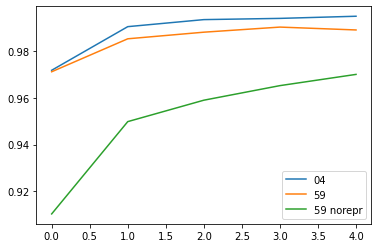

In [49]:
plt.plot(hist_04.history['accuracy'], label="04")
plt.plot(hist_59.history['accuracy'], label="59")
plt.plot(norepr_hist.history['accuracy'], label="59 norepr")
plt.legend()

In [ ]:
tf.keras.utils.plot_model(mnist_59, to_file="model_59.png", show_shapes=True)